In [37]:
import geopandas as gpd
import pandas as pd
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [38]:
# First get the country EEZs
url = "https://files.auspatious.com/unsw/EEZ_land_union_v4_202410.zip"
source_internal_path_name = "EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp"
zip_bytes = requests.get(url).content

with ZipMemoryFile(zip_bytes) as z:
    with z.open(source_internal_path_name) as src:
        eez = gpd.GeoDataFrame.from_features(src, crs=src.crs)

In [39]:
# Only do solomons
eez_solomons = eez[eez["ISO_SOV1"] == "SLB"].to_crs("EPSG:4326")

# Convert to ODC Geometry
eez_solomons_geom = Geometry(eez_solomons.geometry.values[0], crs=eez_solomons.crs)

eez_solomons_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries([eez_solomons_geom.geom]), # Use .geom to get the underlying shapely geometry
    crs=eez_solomons_geom.crs
)

# Now you can use GeoPandas functions:
# eez_solomons_gdf = gpd.clip(eez_solomons_gdf, bbox_solomons)


eez_solomons.explore()

In [40]:
grids = gpd.read_file("twentyfifth_grids.geojson").to_crs("EPSG:4326")

print(len(grids),'total grids')

# bbox_solomons = gpd.read_file("bbox_solomons.geojson")

# Only select solomons grids
# grids_solomons = gpd.clip(grids, bbox_solomons)
condition = grids['GID_0'] == 'SLB'
grids_solomons = grids[condition]

print(len(grids_solomons), 'solomons grids')


27079 total grids
6252 solomons grids


In [44]:
# Only do sol - quarter grids
quarter_grids = gpd.read_file("quarter_grids.geojson").to_crs("EPSG:4326")

print(len(quarter_grids),'total quarter grids')

# bbox_sol = gpd.read_file("bbox_sol.geojson")

# Only select sol grids
# grids_sol = gpd.clip(grids, bbox_sol)
condition = quarter_grids['GID_0'] == 'SLB'
quarter_grids_sol = quarter_grids[condition]

print(len(quarter_grids_sol), 'sols quarter grids')

# quarter_grids_sol = gpd.clip(quarter_grids_sol, eez_sol)
quarter_grids_sol.to_file("quarter_grids_sols.geojson")


1101 total quarter grids
213 sols quarter grids


In [12]:
PACIFIC_EPSG

'EPSG:3832'

<Axes: >

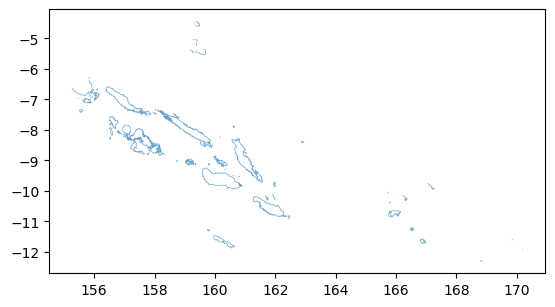

In [13]:
grids_solomons.plot()

In [14]:
grids_solomons = gpd.clip(grids_solomons, eez_solomons)
grids_solomons.to_file("grids_solomons.geojson")

In [15]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_seagrass"],
    # intersects=eez_solomons_geom.json
    intersects=eez_solomons_geom.json
).item_collection()

print(f"Found {len(items)} items")

data = load(
    items,
    bands=["seagrass"],
    crs=PACIFIC_EPSG,  # 
    resolution=100,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)
data


Found 320 items


<xarray.Dataset> Size: 1GB
Dimensions:      (y: 10560, x: 17280, time: 8)
Coordinates:
  * y            (y) float64 84kB -4.48e+05 -4.482e+05 ... -1.504e+06 -1.504e+06
  * x            (x) float64 138kB 5.52e+05 5.522e+05 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [16]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

In [17]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, eez_solomons_geom, variable="seagrass", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        "area_m2": area_m2,
        "area_km2": area_m2 / 1e6
    })

df = pd.DataFrame(results)
df

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


,time,area_m2,area_km2
0,2017,302160000.0,302.16
1,2018,256320000.0,256.32
2,2019,286530000.0,286.53
3,2020,252540000.0,252.54
4,2021,270660000.0,270.66
5,2022,245250000.0,245.25
6,2023,284120000.0,284.12
7,2024,314630000.0,314.63


<Axes: title={'center': 'solomons Seagrass Area Over Time'}, xlabel='time'>

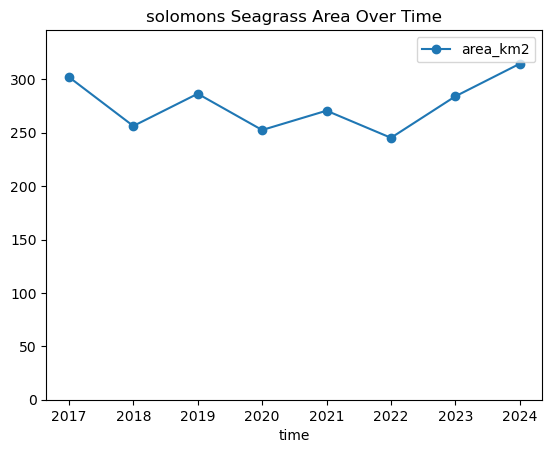

In [18]:
df.plot(x="time", y="area_km2", marker="o", title="solomons Seagrass Area Over Time", ylim=(0, df["area_km2"].max() * 1.1))

In [19]:
for r in results:
    print(f"{r['time']}: {r['area_km2']:.2f} km²")

2017: 302.16 km²
2018: 256.32 km²
2019: 286.53 km²
2020: 252.54 km²
2021: 270.66 km²
2022: 245.25 km²
2023: 284.12 km²
2024: 314.63 km²


In [20]:
data

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 10560, x: 17280, time: 8)
Coordinates:
  * y            (y) float64 84kB -4.48e+05 -4.482e+05 ... -1.504e+06 -1.504e+06
  * x            (x) float64 138kB 5.52e+05 5.522e+05 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [21]:
seagrass_change_2018_2024 = data.seagrass.isel(time=7) - data.seagrass.isel(time=1)

In [22]:
seagrass_2024 = data.seagrass.isel(time=7)
area_m2_seagrass_2024 =  xarray_calculate_area(seagrass_2024, eez_solomons_geom, variable="seagrass", value=1)
area_m2_seagrass_2024
area_km2_seagrass_2024 = area_m2_seagrass_2024/1000000
area_km2_seagrass_2024

314.63

In [23]:
seagrass_2018 = data.seagrass.isel(time=1)
area_m2_seagrass_2018 =  xarray_calculate_area(seagrass_2018, eez_solomons_geom, variable="seagrass", value=1)
area_m2_seagrass_2018
area_km2_seagrass_2018 = area_m2_seagrass_2018/1000000
area_km2_seagrass_2018

256.32

In [24]:
# from matplotlib import colors

# static_classes = [
#     [255, "No_data_1", "#850000", "maroon"],
#     [254, "No_data_2", "#eaed34", "yellow"],
#     [0, "No_seagrass", "#ffa200", "orange"],
#     [1, "Seagrass", "#4ffffa", "teal"],
#     [2, "Other", "#00000000", "transparent"]
# ]

# values_list = [c[0] for c in static_classes]
# static_color_list = [c[2] for c in static_classes]

# static_color_list = [cd[2] for cd in static_classes]
# bounds = values_list + [5]
# static_cmap = colors.ListedColormap(static_color_list)
# norm = colors.BoundaryNorm(bounds, cd_map.N)

In [25]:
# data.seagrass.isel(time=7).odc.explore(cmap = static_cmap)
data.seagrass.isel(time=7).odc.explore(cmap='viridis')

In [26]:
seagrass_change_2018_2024 = data.seagrass.isel(time=7)*-2 - data.seagrass.isel(time=1)

In [27]:
area_m2 = xarray_calculate_area(seagrass_change_2018_2024, eez_solomons_geom, variable="seagrass", value=1)

In [28]:
km2 = area_m2/1000000
km2

0.0

In [29]:
ha = km2*100
ha

0.0

In [30]:
seagrass_change_2018_2024

<xarray.DataArray 'seagrass' (y: 10560, x: 17280)> Size: 365MB
dask.array<sub, shape=(10560, 17280), dtype=int16, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 84kB -4.48e+05 -4.482e+05 ... -1.504e+06 -1.504e+06
  * x            (x) float64 138kB 5.52e+05 5.522e+05 ... 2.28e+06 2.28e+06
    spatial_ref  int32 4B 3832

In [31]:
# from matplotlib import colors

# change_classes = [
#     [-765, "No_data_1", "#00000000", "transparent"],
#     [-511, "No_data_2", "#00000000", "transparent"],
#     [-510, "No_data_3", "#00000000", "transparent"],
#     [-257, "No_data_4", "#00000000", "transparent"],
#     [-255, "No_data_5", "#00000000", "transparent"],
#     [-3, "Increasing", "#4ffffa", "teal"],
#     [-2, "Decreasing", "#850000", "maroon"],
#     [-1, "Constant", "#eaed34", "yellow"]
# ]

# values_list = [c[0] for c in cd_classes]
# cd_color_list = [c[2] for c in cd_classes]

# cd_color_list = [cd[2] for cd in cd_classes]
# bounds = values_list + [8]
# cd_map = colors.ListedColormap(cd_color_list)
# norm = colors.BoundaryNorm(bounds, cd_map.N)

# seagrass_change_2018_2024.odc.explore(cmap =  cd_map)

In [32]:
# seagrass_change_2018_2024.plot(cmap=static_map)

In [33]:
# seagrass_change_2018_2024.odc.explore()

In [34]:
seagrass_change_2018_2024.odc.write_cog("seagrass_change_2018_2024_solomons.tiff", overwrite=True)

PosixPath('seagrass_change_2018_2024_solomons.tiff')

In [35]:
seagrass_2018.odc.write_cog("seagrass_2018_solomons.tiff")

PosixPath('seagrass_2018_solomons.tiff')

In [36]:
seagrass_2024.odc.write_cog("seagrass_2024_solomons.tiff")

PosixPath('seagrass_2024_solomons.tiff')